# Objetivos do caderno
- Selecionar 50% de homens e 50% de mulheres
- Salvar em uma lista o nome das pessoas selecionadas
- Extrair 10 extratos de áudio de cada

In [1]:
import pandas as pd
import numpy as np
import os
import sphfile as sph
import matplotlib.pyplot as plt
import librosa
import ipywidgets as widgets
import scipy.io.wavfile as wav
from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sb

plt.style.use('ggplot')

import keras
import tensorflow as tf
from tensorflow.keras.layers import *


Bad key "text.kerning_factor" on line 4 in
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Selecionar 50% homens e 50% mulheres

In [2]:
palestras=pd.read_excel("Registro_Palestrantes.xlsx",index_col=0)

In [3]:
palestras.Sexo.value_counts()

M    580
F    169
Name: Sexo, dtype: int64

In [4]:
palestras.Sexo.value_counts()

M    580
F    169
Name: Sexo, dtype: int64

In [5]:
samp_m=palestras[palestras.Sexo=='M'].sample(100)
samp_f=palestras[palestras.Sexo=='F'].sample(100)
samp=samp_m.append(samp_f)
samp=samp.sample(frac=1)

In [6]:
samp=samp.iloc[:,:5]

In [74]:
np.random.seed(42)
samp['Set2']=['Teste' if i>0.9 else 'Treino' for i in np.random.rand(samp.shape[0])]

In [76]:
samp['Set2'].value_counts()

Treino    181
Teste      19
Name: Set2, dtype: int64

In [77]:
samp.to_parquet('Palestrantes_Selecionados.parquet')

## Extrair 10 extratos de áudio de cada

In [78]:
try:
    samp==1
except:
    samp=pd.read_parquet('Palestrantes_Selecionados.parquet')

# #####
# Mudar o formato do dataframe
# #####

| Nome | Ano | Sexo | t_min | t_max 

In [79]:
samp=samp.reset_index(drop=True)

In [80]:
samp.Sexo=samp.Sexo.replace({'M':1,'F':0})

In [81]:
samp

,Nome,Ano,Set,Sexo,Primo Nome,Set2
0,Thomas Thwaites,2010,Train,1,Thomas,Treino
1,Nate Silver,2009,Train,1,Nate,Teste
2,Steven Levitt,2004,Train,1,Steven,Treino
3,Diane Benscoter,2009,Train,0,Diane,Treino
4,George Ayittey,2007,Train,1,George,Treino
...,...,...,...,...,...,...
195,David Deutsch,2005,Train,1,David,Treino
196,Carl Safina,2010,Train,1,Carl,Treino
197,Rick Smolan,2007,Train,1,Rick,Treino
198,Tierney Thys,2003,Train,0,Tierney,Treino


In [82]:
df=pd.DataFrame(columns=['Nome','Ano','Sexo','Set','t_min','t_max','AudioName','Grupo'])

In [83]:
for indice in samp.index:
    try:
        nome=samp.loc[indice,'Nome'].replace(' ','')
        ano=str(samp.loc[indice,'Ano'])
        sexo=samp.loc[indice,'Sexo']
        set_=samp.loc[indice,'Set'].lower()
        grupo=samp.loc[indice,'Set2']
        audio_name=[x for x in os.listdir(f"TEDLIUM_release1/{set_}/sph/") if x.startswith(nome+'_'+ano)][0]
        audio=sph.SPHFile(f"TEDLIUM_release1/{set_}/sph/{audio_name}")
        texto=[x for x in os.listdir(f"TEDLIUM_release1/{set_}/stm/") if x.startswith(nome+'_'+ano)][0]
        tr=open((f"TEDLIUM_release1/{set_}/stm/{texto}"))
        texto=tr.readlines()
        tr.close()

        tempo=[tuple(tx.split(' ')[3:5]) for tx in texto]
        tempo=[(float(t[0]),float(t[1])) for t in tempo]
        duration=[float(t[1])-float(t[0]) for t in tempo]
        idx=np.where(pd.Series(duration)>2)[0]
        
        
        sr=audio.format['sample_rate']
        for t in range(len(idx)):
            init=np.round(tempo[idx[t]][0]+duration[idx[t]]*np.random.rand())
            end=init+2
            df=df.append(pd.DataFrame(dict(zip(df.columns,[nome,ano,sexo,set_,init,end,audio_name,grupo])),index=[0]),ignore_index=True)
        
        
#         corte=[(int(t[0]*sr),int(t[1]*sr)) for t in tempo]        
        
#         corte=[audio.content[c[0]:c[1]] for c in corte]
#         corte=[corte[i].astype(float) for i in idx]
        
    #    print(4)
#         for ct in corte:
#             along=0.95+0.1*np.random.rand()
#             intensidade=0.9+0.2*np.random.rand()
#             c_along=intensidade*librosa.effects.time_stretch(ct,along)
#     #        print(5)
#             for j in range(5):
#                 try:
#                     init=np.random.randint(c_along.shape[0]-32000)
#                     trilha=np.vstack([trilha,np.concatenate((c_along[init:init+32000],np.array([samp.loc[indice,'Sexo']])))])
#                 except:
#                     pass
    except:
        print(indice)

8
81


In [84]:
df['path']=df.Nome+'_'+df.Ano

In [85]:
df

,Nome,Ano,Sexo,Set,t_min,t_max,AudioName,Grupo,path
0,ThomasThwaites,2010,1,train,111.0,113.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
1,ThomasThwaites,2010,1,train,116.0,118.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
2,ThomasThwaites,2010,1,train,136.0,138.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
3,ThomasThwaites,2010,1,train,151.0,153.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
4,ThomasThwaites,2010,1,train,23.0,25.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
...,...,...,...,...,...,...,...,...,...
13378,DavidGriffin,2008,1,train,86.0,88.0,DavidGriffin_2008.sph,Treino,DavidGriffin_2008
13379,DavidGriffin,2008,1,train,855.0,857.0,DavidGriffin_2008.sph,Treino,DavidGriffin_2008
13380,DavidGriffin,2008,1,train,859.0,861.0,DavidGriffin_2008.sph,Treino,DavidGriffin_2008
13381,DavidGriffin,2008,1,train,874.0,876.0,DavidGriffin_2008.sph,Treino,DavidGriffin_2008


In [86]:
df.to_csv('df_in.csv',index=False)

In [87]:
df.Nome.nunique()

188

In [88]:
df.head()

,Nome,Ano,Sexo,Set,t_min,t_max,AudioName,Grupo,path
0,ThomasThwaites,2010,1,train,111.0,113.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
1,ThomasThwaites,2010,1,train,116.0,118.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
2,ThomasThwaites,2010,1,train,136.0,138.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
3,ThomasThwaites,2010,1,train,151.0,153.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010
4,ThomasThwaites,2010,1,train,23.0,25.0,ThomasThwaites_2010S.sph,Treino,ThomasThwaites_2010


In [89]:
df.Sexo.value_counts(normalize=True)

1    0.510498
0    0.489502
Name: Sexo, dtype: float64

In [90]:
try:
    type(df)==pd.DataFrame
except:
    df=pd.read_csv('./df_in.csv')

In [91]:
n_fft=512
hop_length=1024

In [92]:
def get_features(df_in):
    features=[] #list to save features
    labels=[] #list to save labels
    for index in df_in.index:
        filename=f"TEDLIUM_release1/{df_in.loc[index,'Set']}/sph/{df_in.loc[index,'AudioName']}" #get the filename
        tstart = df_in.loc[index,'t_min'] 
        tend = df_in.loc[index,'t_max'] 
        species_id = df_in.loc[index,'Sexo'] 
        #load the file
        sph_=sph.SPHFile(filename)
        y=np.array(sph_.time_range(df_in.loc[index,'t_min'],df_in.loc[index,'t_max']),dtype='float32')
        sr = sph_.format['sample_rate']
        data = np.array(librosa.feature.mfcc(y,n_fft=n_fft,hop_length=hop_length,n_mfcc=30))
        features.append(data)
        labels.append(species_id)
    output=np.concatenate(features,axis=0)
    return(np.array(output), labels)

In [93]:
X_train,y_train=get_features(df[df.Grupo=='Treino'])
X_test,y_test=get_features(df[df.Grupo=='Teste'])

In [94]:
XX=(X_train,X_test)
yy=(y_train,y_test)

import joblib

joblib.dump((XX,yy),'intermediario.pickle')

In [95]:
media=np.mean(X_train)
desv=np.std(X_train)

In [96]:
X_train = np.array((X_train-media)/desv)
X_test = np.array((X_test-media)/desv)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [97]:
X_train=X_train.reshape(y_train.shape[0],-1,32)
X_test=X_test.reshape(y_test.shape[0],-1,32)

In [98]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=314, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=314)
#Print the shapes
X_train.shape, X_test.shape, X_val.shape, len(y_train), len(y_test), len(y_val)

((9051, 30, 32), (1314, 30, 32), (3018, 30, 32), 9051, 1314, 3018)

In [99]:
X_train.shape

(9051, 30, 32)

In [100]:
y_train.mean()

0.4998342724560822

In [101]:
y_val.mean()

0.4983432736911862

In [102]:
y_test.mean()

0.6118721461187214

In [129]:
input_shape=X_train.shape[1:]
model = tf.keras.Sequential()
model.add(LSTM(128,input_shape=input_shape,return_sequences=True))
model.add(LSTM(96))
model.add(Dropout(0.2))
#model.add(Dense(128, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))
#model.summary()

ES=tf.keras.callbacks.EarlyStopping(patience=10)
RLR=tf.keras.callbacks.ReduceLROnPlateau()
model.compile(optimizer='adam',loss='SparseCategoricalCrossentropy',metrics=['acc'])

history = model.fit(X_train, y_train, epochs=200, batch_size=int(X_train.shape[0]**0.5),
                    validation_data=(X_val, y_val),callbacks=[ES,RLR])

Epoch 1/200
96/96 [==============================] - 12s 46ms/step - loss: 0.6882 - acc: 0.5281 - val_loss: 0.5584 - val_acc: 0.7568
Epoch 2/200
96/96 [==============================] - 3s 33ms/step - loss: 0.5564 - acc: 0.7420 - val_loss: 0.4661 - val_acc: 0.8022
Epoch 3/200
96/96 [==============================] - 2s 22ms/step - loss: 0.5063 - acc: 0.7707 - val_loss: 0.4465 - val_acc: 0.8062
Epoch 4/200
96/96 [==============================] - 2s 22ms/step - loss: 0.4741 - acc: 0.7968 - val_loss: 0.4489 - val_acc: 0.8098
Epoch 5/200
96/96 [==============================] - 2s 22ms/step - loss: 0.4574 - acc: 0.8082 - val_loss: 0.4697 - val_acc: 0.7889
Epoch 6/200
96/96 [==============================] - 2s 22ms/step - loss: 0.4676 - acc: 0.8005 - val_loss: 0.4664 - val_acc: 0.7985
Epoch 7/200
96/96 [==============================] - 2s 22ms/step - loss: 0.4658 - acc: 0.8064 - val_loss: 0.4404 - val_acc: 0.8085
Epoch 8/200
96/96 [==============================] - 2s 22ms/step - loss: 0

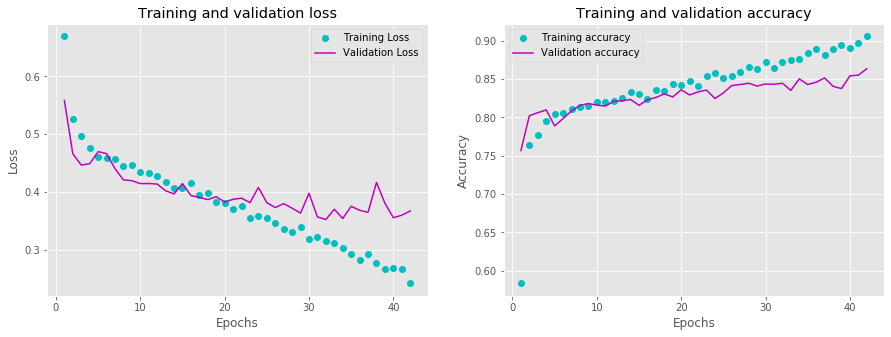

In [130]:
#Adapted from Deep Learning with Python by Francois Chollet, 2018
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['acc']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_acc']
epochs=range(1,len(history.history['loss'])+1)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [131]:
TrainLoss, Trainacc = model.evaluate(X_train,y_train)
TestLoss, Testacc = model.evaluate(X_test, y_test)
y_pred=model.predict(X_test)

42/42 [==============================] - ETA: 0s - loss: 0.4824 - acc: 0.822 - 0s 6ms/step - loss: 0.5041 - acc: 0.8105


In [132]:
import scikitplot as skplt

Function plot_ks_statistic is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_ks_statistic instead.


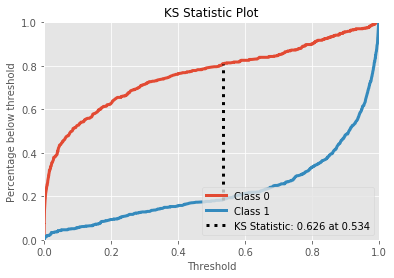

In [133]:
skplt.plotters.plot_ks_statistic(y_test,y_pred)

Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.


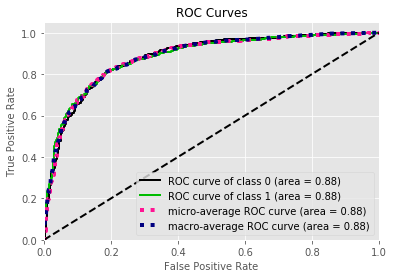

In [134]:
skplt.plotters.plot_roc_curve(y_test,y_pred)

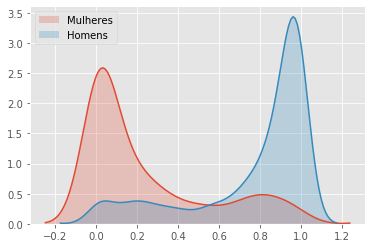

In [135]:
sb.kdeplot(y_pred[y_test==0,1],shade=True)
sb.kdeplot(y_pred[y_test==1,1],shade=True)
plt.legend(['Mulheres','Homens'])

In [136]:
import scipy.stats as st 

In [137]:
best_threshold=st.ks_2samp(y_pred[y_test==0,1],y_pred[y_test==1,1])[0]

In [138]:
metrics.confusion_matrix(y_test,y_pred[:,1]>best_threshold)/y_test.shape[0]

array([[0.32191781, 0.06621005],
       [0.13394216, 0.47792998]])

In [139]:
metrics.confusion_matrix(y_test,y_pred[:,1]>0.5)/y_test.shape[0]

array([[0.30821918, 0.07990868],
       [0.10958904, 0.50228311]])

# 

In [140]:
print(metrics.classification_report(y_test,y_pred[:,1]>best_threshold))

              precision    recall  f1-score   support

           0       0.71      0.83      0.76       510
           1       0.88      0.78      0.83       804

    accuracy                           0.80      1314
   macro avg       0.79      0.81      0.79      1314
weighted avg       0.81      0.80      0.80      1314



In [141]:
print(metrics.classification_report(y_test,y_pred[:,1]>0.5))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       510
           1       0.86      0.82      0.84       804

    accuracy                           0.81      1314
   macro avg       0.80      0.81      0.80      1314
weighted avg       0.81      0.81      0.81      1314



# Análise de erro

In [142]:
X_train.shape,X_val.shape,X_test.shape

((9051, 30, 32), (3018, 30, 32), (1314, 30, 32))

In [143]:
X_train.shape[0]+X_val.shape[0]+X_test.shape[0]

13383

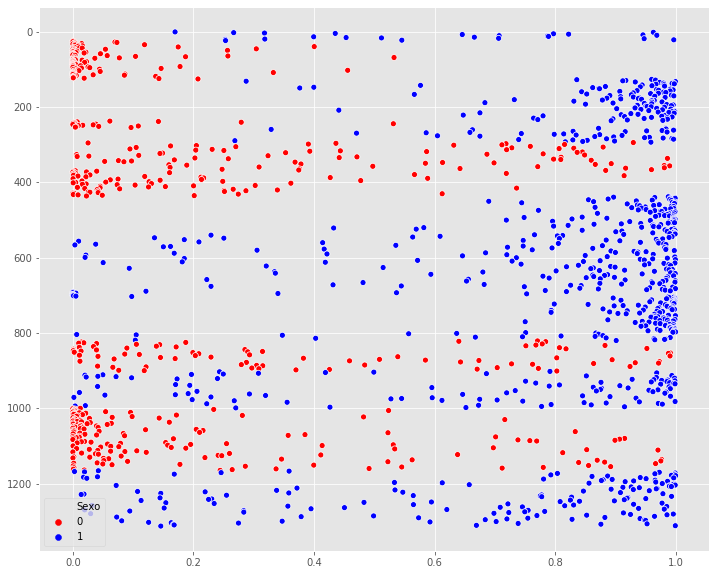

In [144]:
fig,ax=plt.subplots(figsize=(12,10))
ax.invert_yaxis()
sb.scatterplot(x=y_pred[:,1],y=range(X_test.shape[0]),hue=df[df.Grupo=='Teste'].Sexo,palette=['r','b'])

In [145]:
result_test=df[df.Grupo=='Teste']

In [146]:
result_test['pred']=y_pred[:,1]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


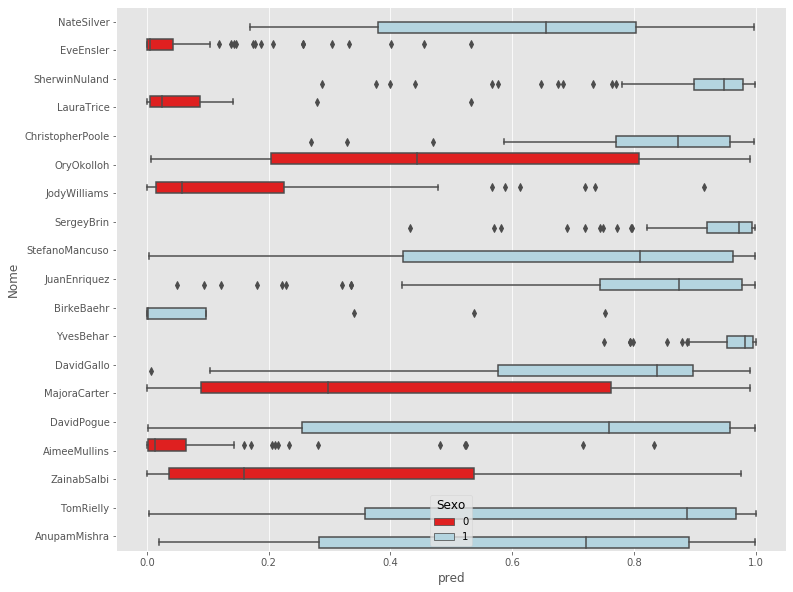

In [151]:
plt.figure(figsize=(12,10))
sb.boxplot(y=result_test['Nome'],x=result_test['pred'],hue=result_test.Sexo,palette=['r','lightblue'])

Agrupando as classificações por palestrantes, vemos que a maioria das distribuições de predições estão de acordo com o sexo do palestrante. Existem alguns palestrantes que errarram levemente e outros que erraram gravemente.
<ol>
    <li>
        Erros leves: dentre esses casos, ou eram homens com vozes mais finas (Nate Silver e Tom Rielly), ou mulheres com vozes mais graves (Majora Carter), ou estrangeiros com sotaque (Ory Okolloh e Anupan Mishra)
        <ul>
            <li>Nate Silver</li>
            <li>Ory Okolloh</li>            
            <li>Majora Carter</li>
            <li>Tom Rielly</li>
            <li>Anupam Mishra</li>
        </ul>
    </li>
    <li>
        Erros graves: o palestrante é uma criança de 11 anos, o que explica a classificação como mulher. 
            <ul>
            <li>BirkeBaehr</li>
        </ul>
    </li>
</ol>

In [153]:
model.save_weights("model_weights.h5")
model.save("model.h5")